# Model Tuning

In this notebook, I'll be following up on the top-scoring models of the last trials, and attempting to optimize the hyperparameters for even better test scores.

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import warnings
warnings.simplefilter('ignore')

pd.options.display.max_colwidth = 200

In [2]:
reddit = pd.read_csv('../datasets/reddit_slimmed.csv')
reddit.drop(columns='Unnamed: 0', inplace=True)
reddit['subreddit_class'] = reddit['subreddit_class'].map({'ohio': 0, 'ihateohio': 1})
reddit.head(1)

,subreddit_class,title,selftext,author,title_word_count,selftext_word_count
0,0,about the donovan lewis police shooting in columbus.,donovan reacted as naturally as anyone would when strangers burst open your bedroom door. there is inherent risk when serving a warrant and going through someone’s home unwelcomed. cops need to re...,barelycriminal,8,48


In [3]:
# Reading in the model trials dataframe to see which scores performed the best and which models to further test on

model_trials = pd.read_csv('../datasets/model_trials.csv')
model_trials.drop(columns='Unnamed: 0', inplace=True)
model_trials.head(3)

,model_used,title_train_score,title_test_score,selftext_train_score,selftext_test_score
0,CVec Logistic Regression,0.956551,0.756684,0.854947,0.863636
1,TfVec Logistic Regression,0.920455,0.732620,0.871658,0.847594
2,CVec Mn Naive Bayes,0.947861,0.743316,0.596257,0.526738


---

## Top Performing Models

In [4]:
top_models = model_trials[['model_used', 'selftext_test_score']].sort_values(by=['selftext_test_score'], ascending=False).head(10)
top_models['vec_flag'] = [1 if 'CVec' in s else 0 for s in top_models['model_used']]

top_models

,model_used,selftext_test_score,vec_flag
0,CVec Logistic Regression,0.863636,1
17,TfVec Gradient Boosting,0.860963,0
10,CVec Bagging,0.858289,1
16,CVec Gradient Boosting,0.858289,1
12,CVec AdaBoosting,0.855615,1
11,TfVec Bagging,0.852941,0
6,CVec Decision Tree,0.850267,1
1,TfVec Logistic Regression,0.847594,0
13,TfVec AdaBoosting,0.847594,0
8,CVec Random Forest,0.844920,1


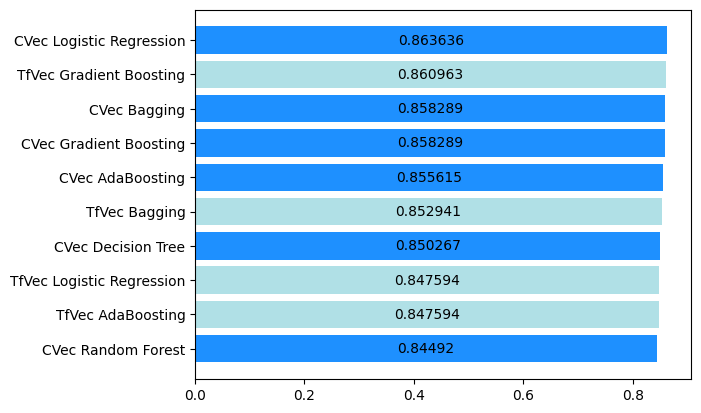

In [5]:
fig, ax = plt.subplots()

colors = ['dodgerblue' if num == 1 else 'powderblue' for num in top_models['vec_flag']]
tm = ax.barh(top_models['model_used'][::-1], width=top_models['selftext_test_score'][::-1], color=colors[::-1])
ax.bar_label(tm, label_type='center')
plt.show();

We can see that four out of the five top-scoring models used CountVectorizer, but the top ten is an almost even split. I'll be In the coming model tuning, I'll be testing both Vectorizers in all models (with added hyperparameter tuning) to see what performs the best.

Because all of these scores came from using the selftext column (as opposed to using the title column) as X, I'll be moving forward with this as the only predictor variable. 

---

## Building a Function to GridSearch Models

Similar to the model trials function, I'll be writing another that takes a few extra arguments and will grid search over the updated pipelines. 

In [6]:
grid_search_df = pd.DataFrame(columns=['model_used', 'cross_val_score', 'train_score', 'test_score', 'misclass_rate'])

In [7]:
def grid_search(pipe, pipe_params, model_id):

    '''Setting X and y, then splitting into train and test sets'''
    X = reddit['selftext']
    y = reddit['subreddit_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    '''Instantiating GridSearchCV'''
    gs = GridSearchCV(pipe, param_grid=pipe_params, n_jobs= -1, verbose=1, cv = 3)
    gs.fit(X_train, y_train)

    '''GridSearch-specific values'''
    cross_val_score = gs.best_score_
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    best_params = gs.best_params_
    best_estimator = gs.best_estimator_

    '''Calculating accuracy and misclassification rates'''
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    misclass = 1 - acc

    '''Ensuring that models with more parameters can be appended to grid_search_df'''
    for i in range(len(best_params)):
        if f'best_param_{i+1}' not in grid_search_df.columns:
            grid_search_df[f'best_param_{i+1}'] = '-'

    '''Adding the best model scores and hyperparameters to the list of model attributes'''
    model_list = [model_id, cross_val_score, train_score, test_score, misclass]
    for k, v in best_params.items():
        model_list.append((k,v))

    '''Ensuring that models with less parameters can be appended to grid_search_df'''
    if len(model_list) < len(grid_search_df.columns):
        extra_cols = len(grid_search_df.columns) - len(model_list)
        for i in range(extra_cols):
            count = extra_cols
            filler = []
            while count > 0:
                filler.append('-')
                count -= 1
        model_list.extend(filler)        

    '''Appending all numbers and params to the dataframe'''
    grid_search_df.loc[len(grid_search_df.index)] = model_list

    '''Output will show me all scores to see how they compare to each other'''
    print(f'Best Params: {best_params}  \n')
    print(f'Best Estimator Cross Val Score: {round(cross_val_score, 5)}')
    print(f'{model_id} Training Score: {round(train_score, 5)}')
    print(f'{model_id} Testing Score: {round(test_score, 5)}')
    print(f'Misclassification Rate: {round(misclass, 5)} \n')

    '''Returning a confusion matrix'''
    print('Best estimator confusion matrix:')
    if test_score < 0.8:
        return plot_confusion_matrix(best_estimator, X_test, y_test, cmap='bone', values_format='d', display_labels=['ohio', 'ihateohio']);
    else:
        return plot_confusion_matrix(best_estimator, X_test, y_test, cmap='coolwarm', values_format='d', display_labels=['ohio', 'ihateohio']);

Again, I'll be defining the pipeline and hyperparameters I want to use in each model, and the function will output the best-performing model's parameters, all relevant scores, and a confusion matrix showing the distribution of predictions.

I think the matrices are really useful in visualizing where each model is underperforming, and can also help identify if there are patterns with some harder-to-classify posts.

---

## Logistic Regression

In [8]:
cvec_lr = Pipeline([
        ('cvec', CountVectorizer()),
        ('lr', LogisticRegression(max_iter= 50_000, solver='saga', random_state=42))
])

cvec_lr_params = {
    'cvec__max_features': [1500, 2000, 3000],
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.7, .8],
    'lr__C': [.1, 10],
    'lr__penalty': ['l2', 'l1']

}

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Params: {'cvec__max_df': 0.7, 'cvec__max_features': 1500, 'cvec__min_df': 1, 'cvec__stop_words': None, 'lr__C': 10, 'lr__penalty': 'l1'}  

Best Estimator Cross Val Score: 0.84892
CVec Logistic Regression Training Score: 0.90174
CVec Logistic Regression Testing Score: 0.86364
Misclassification Rate: 0.13636 

Best estimator confusion matrix:


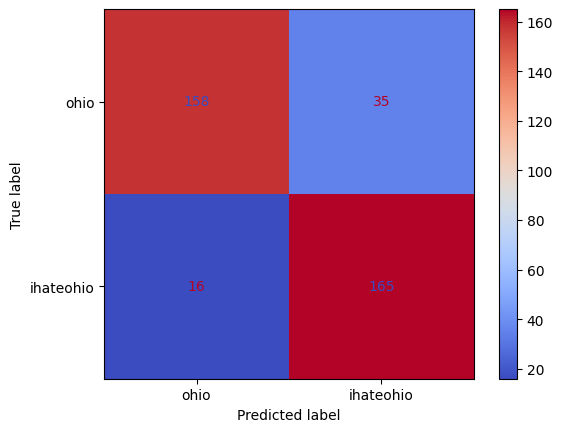

In [9]:
grid_search(cvec_lr, cvec_lr_params, 'CVec Logistic Regression')

In [10]:
cvec_lr_2 = Pipeline([
        ('cvec', CountVectorizer(stop_words=None, min_df=1)),
        ('lr', LogisticRegression(max_iter= 50_000, solver='saga', penalty='l1', random_state=42))
])

cvec_lr_params_2 = {
    'cvec__max_features': [1000, 1250, 1500],
    'cvec__max_df': [.6, .65, .7],
    'lr__C': [10, 20]}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'cvec__max_df': 0.6, 'cvec__max_features': 1500, 'lr__C': 10}  

Best Estimator Cross Val Score: 0.84892
CVec Logistic Regression_v2 Training Score: 0.90174
CVec Logistic Regression_v2 Testing Score: 0.86364
Misclassification Rate: 0.13636 

Best estimator confusion matrix:


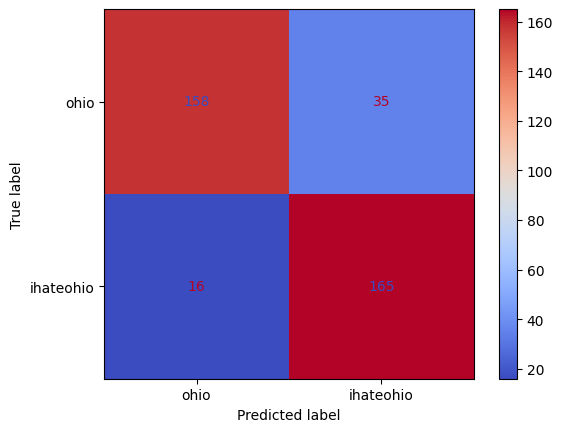

In [11]:
grid_search(cvec_lr_2, cvec_lr_params_2, 'CVec Logistic Regression_v2')

In [12]:
tfvec_lr = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('lr', LogisticRegression(max_iter= 50_000, solver='saga', penalty='l1', random_state=42))
])

tfvec_lr_params = {
    'tfvec__max_features': [1000, 1250, 1500],
    'tfvec__max_df': [.6, .65, .7],
    'tfvec__min_df': [1, 2],
    'lr__C': [1, 10],

}

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params: {'lr__C': 10, 'tfvec__max_df': 0.6, 'tfvec__max_features': 1000, 'tfvec__min_df': 1}  

Best Estimator Cross Val Score: 0.83623
TfVec Logistic Regression Training Score: 0.92112
TfVec Logistic Regression Testing Score: 0.85561
Misclassification Rate: 0.14439 

Best estimator confusion matrix:


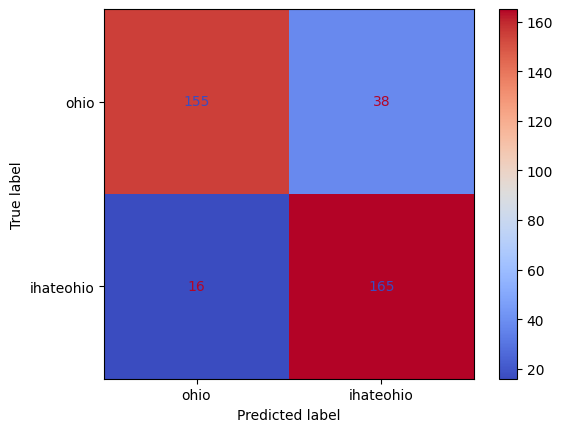

In [13]:
grid_search(tfvec_lr, tfvec_lr_params, 'TfVec Logistic Regression')

### Analysis

Both LogReg models above that used CountVectorizer had greater train scores than when the model ran with no hyperparameters (5% increase), but the same test scores seen in the no-param (np) model. We are probably slightly overfit here.

The Tfidf model had greater training and test scores after hyperparameter tuning.

Despite the equal CVec scores, the predictions made have changed. The models above are better at predicting IHateOhio posts, but worse at predicting Ohio posts.

---

## Gradient Boosting Classifier

I'm starting with Tfidf here because it scored higher than the GBoost model that used CountVectorizer.

In [14]:
tfvec_gboost = Pipeline([
    ('tfvec', TfidfVectorizer()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

tfvec_gboost_params  = {
    'tfvec__stop_words': [None, 'english'],
    'gb__n_estimators': [100, 150, 200], 
    'gb__max_depth': [5, 7, 8],
    'gb__learning_rate': [0.7, 0.8, 0.85] 
}

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Params: {'gb__learning_rate': 0.8, 'gb__max_depth': 8, 'gb__n_estimators': 150, 'tfvec__stop_words': None}  

Best Estimator Cross Val Score: 0.84158
TfVec GBoost Training Score: 0.92848
TfVec GBoost Testing Score: 0.85829
Misclassification Rate: 0.14171 

Best estimator confusion matrix:


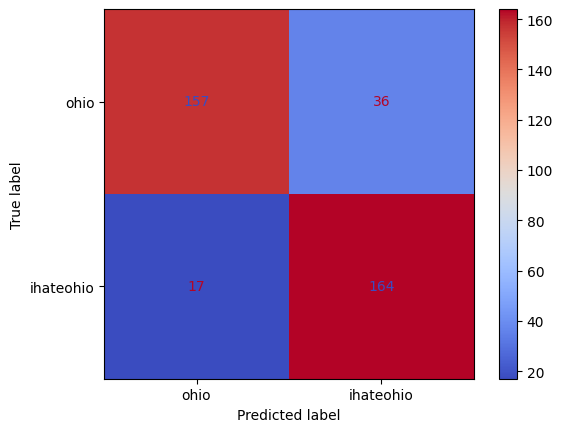

In [15]:
grid_search(tfvec_gboost, tfvec_gboost_params, 'TfVec GBoost')

In [16]:
tfvec_gboost_2 = Pipeline([
    ('tfvec', TfidfVectorizer(stop_words=None)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

tfvec_gboost_params_2  = {
    'gb__max_depth': [5, 7, 8],
    'gb__learning_rate': [0.6, 0.75, 0.8],
    'gb__validation_fraction': [.05, .1],
    'gb__n_iter_no_change': [5, 10, 20],
    'gb__tol': [.03, .05, .1]
}

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Params: {'gb__learning_rate': 0.8, 'gb__max_depth': 5, 'gb__n_iter_no_change': 20, 'gb__tol': 0.03, 'gb__validation_fraction': 0.05}  

Best Estimator Cross Val Score: 0.8369
TfVec GBoost_v2 Training Score: 0.92112
TfVec GBoost_v2 Testing Score: 0.85829
Misclassification Rate: 0.14171 

Best estimator confusion matrix:


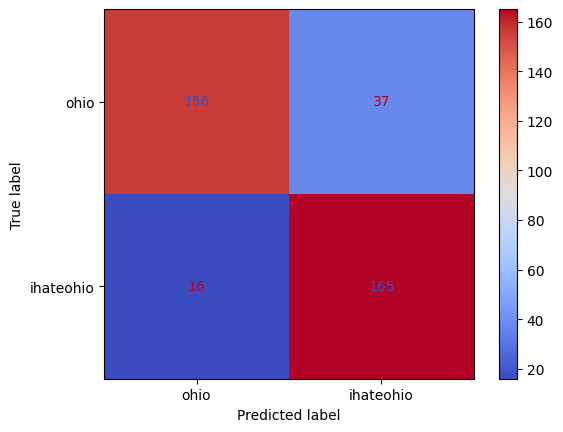

In [17]:
grid_search(tfvec_gboost_2, tfvec_gboost_params_2, 'TfVec GBoost_v2')

In [18]:
cvec_gboost = Pipeline([
    ('cvec', CountVectorizer(stop_words=None)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

cvec_gboost_params  = {
    'gb__n_estimators': [100, 150, 200], 
    'gb__max_depth': [5, 7, 8],
    'gb__learning_rate': [0.7, 0.8, 0.85] 
}

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Params: {'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__n_estimators': 100}  

Best Estimator Cross Val Score: 0.83957
CVec GBoost Training Score: 0.92848
CVec GBoost Testing Score: 0.87166
Misclassification Rate: 0.12834 

Best estimator confusion matrix:


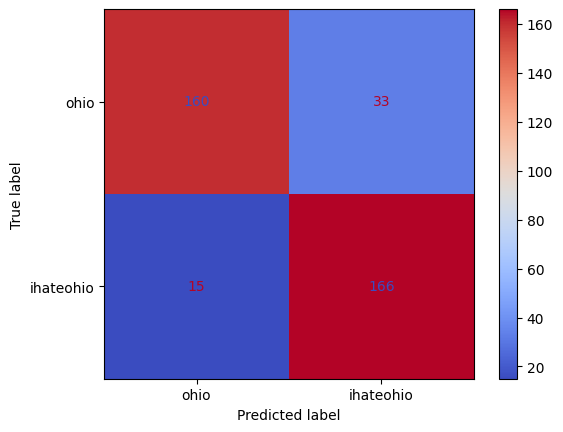

In [19]:
grid_search(cvec_gboost, cvec_gboost_params, 'CVec GBoost')

### Analysis

GBoost modeling continues to perform well on this dataset. My theory is that while Decision Trees are a moderately-scoring predictor, when used as the weak learner in GBoosting and weighed according to accuracy (my target metric), the model becomes a bit more adept and outscores both Decision Tree models on their own and Random Forest.

The Tfidf Gradient Boost model was the highest-scoring in the no-params model trials, but in the above tests, the ~0.85 scores decreased from the original value of 0.86096. 

I used the same hypermeters for the CountVectorizer test, and the score jumped from the previous 0.85829 to 0.87166 in the model above.

Because the Gradient Boost model has performed well in all trials, I anticipate that I'll be using it in my final model.

---

## Bagging Classifier

In [20]:
cvec_bag = Pipeline([
        ('cvec', CountVectorizer()),
        ('bag', BaggingClassifier(random_state=42))
])

cvec_bag_params = {
    'cvec__stop_words': [None, 'english'],
    'bag__n_estimators': [200, 400, 600],
    'bag__max_features': [200, 300, 400],
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'bag__max_features': 400, 'bag__n_estimators': 600, 'cvec__stop_words': None}  

Best Estimator Cross Val Score: 0.80682
CVec Bagging Training Score: 0.8857
CVec Bagging Testing Score: 0.8262
Misclassification Rate: 0.1738 

Best estimator confusion matrix:


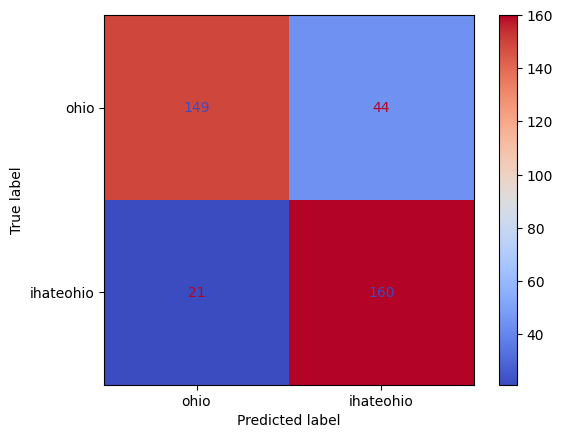

In [21]:
grid_search(cvec_bag, cvec_bag_params, 'CVec Bagging')

In [22]:
cvec_bag_2 = Pipeline([
        ('cvec', CountVectorizer()),
        ('bag', BaggingClassifier(random_state=42))
])

cvec_bag_params_2 = {
    'cvec__stop_words': [None, 'english'],
    'bag__n_estimators': [200, 400, 600],
    'bag__max_samples': [300, 400, 500], 
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'bag__max_samples': 400, 'bag__n_estimators': 200, 'cvec__stop_words': None}  

Best Estimator Cross Val Score: 0.81952
CVec Bagging_v2 Training Score: 0.8496
CVec Bagging_v2 Testing Score: 0.85561
Misclassification Rate: 0.14439 

Best estimator confusion matrix:


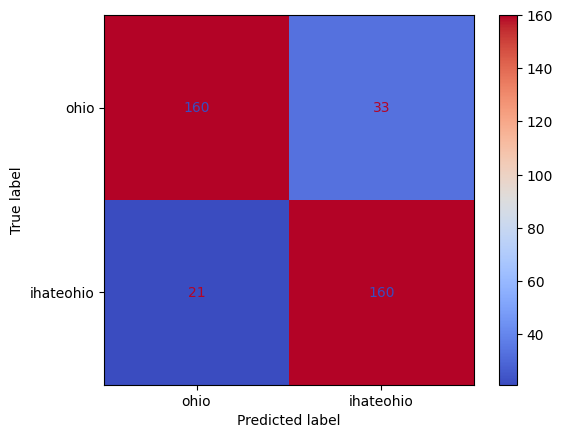

In [23]:
grid_search(cvec_bag_2, cvec_bag_params_2, 'CVec Bagging_v2')

In [24]:
tfvec_bag = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('bag', BaggingClassifier(random_state=42))
])

tfvec_bag_params = {
    'bag__n_estimators': [200, 400, 600],
    'bag__max_samples': [300, 400, 500], 
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'bag__max_samples': 400, 'bag__n_estimators': 200}  

Best Estimator Cross Val Score: 0.82085
TfVec Bagging Training Score: 0.85294
TfVec Bagging Testing Score: 0.84225
Misclassification Rate: 0.15775 

Best estimator confusion matrix:


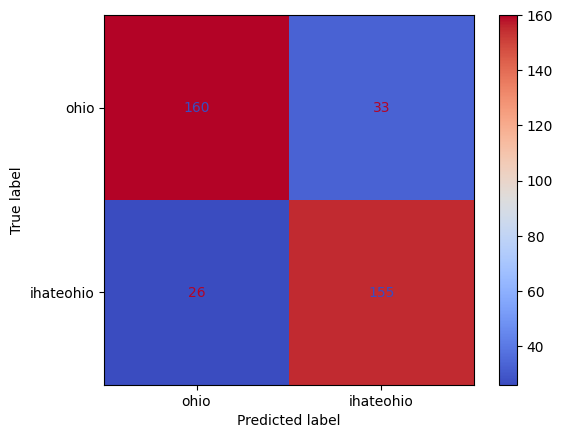

In [25]:
grid_search(tfvec_bag, tfvec_bag_params, 'TfVec Bagging')

### Analysis

The best-performing model above was the second version of the CVec model. I updated the hyperparameters because max_samples pulls samples with replacement but max_features does not. Making this change looks to have decreased the false positives, and increased the number of true 'negatives' (Ohio predictions).

The Tfidf model scored slightly worse with hyperparameters added, dropping from a previous 0.85294, to 0.84225.

Regardless, I think that bagging would be effective in a stacked model, so I'll likely use the CVec version 2 above as one of the level-one estimators.

---

## AdaBoost Classifier

In [26]:
cvec_ada = Pipeline([
        ('cvec', CountVectorizer()),
        ('ada', AdaBoostClassifier(random_state=42))
])

cvec_ada_params = {
    'cvec__stop_words': [None, 'english'],
    'ada__n_estimators': [100, 200, 300],
    'ada__learning_rate': [0.7, 0.8, 0.9],
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'ada__learning_rate': 0.8, 'ada__n_estimators': 300, 'cvec__stop_words': None}  

Best Estimator Cross Val Score: 0.83356
Cvec AdaBoost Training Score: 0.92848
Cvec AdaBoost Testing Score: 0.85027
Misclassification Rate: 0.14973 

Best estimator confusion matrix:


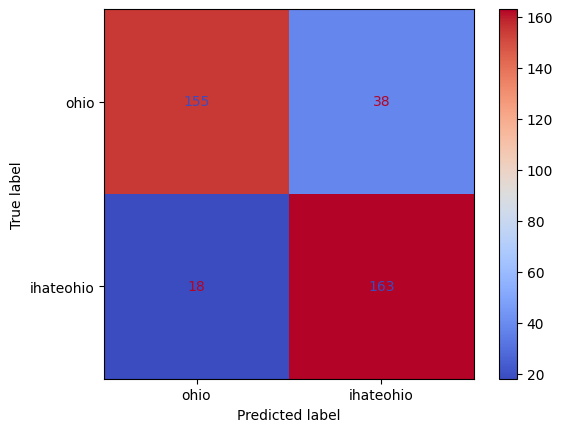

In [27]:
grid_search(cvec_ada, cvec_ada_params, 'Cvec AdaBoost')

In [28]:
cvec_ada_2 = Pipeline([
        ('cvec', CountVectorizer(stop_words=None)),
        ('ada', AdaBoostClassifier(random_state=42))
])

cvec_ada_params_2 = {
    'ada__n_estimators': [300, 350, 400],
    'ada__learning_rate': [0.6, 0.65, 0.7],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'ada__learning_rate': 0.65, 'ada__n_estimators': 400}  

Best Estimator Cross Val Score: 0.83423
CVec AdaBoost_v2 Training Score: 0.92848
CVec AdaBoost_v2 Testing Score: 0.86364
Misclassification Rate: 0.13636 

Best estimator confusion matrix:


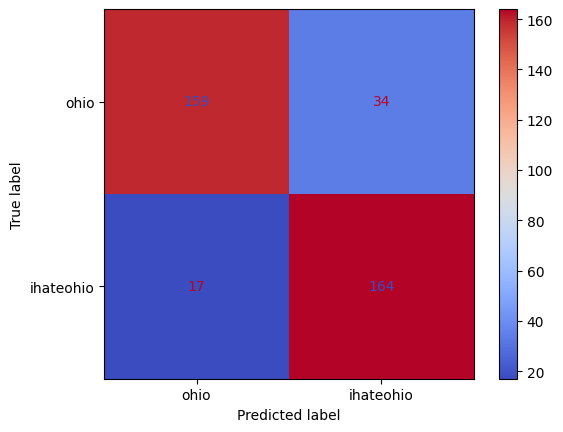

In [29]:
grid_search(cvec_ada_2, cvec_ada_params_2, 'CVec AdaBoost_v2')

In [30]:
tfvec_ada = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('ada', AdaBoostClassifier(random_state=42))
])

tfvec_ada_params = {
    'ada__n_estimators': [300, 350, 400],
    'ada__learning_rate': [0.6, 0.65, 0.7],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'ada__learning_rate': 0.7, 'ada__n_estimators': 400}  

Best Estimator Cross Val Score: 0.83891
TfVec AdaBoost Training Score: 0.92848
TfVec AdaBoost Testing Score: 0.85027
Misclassification Rate: 0.14973 

Best estimator confusion matrix:


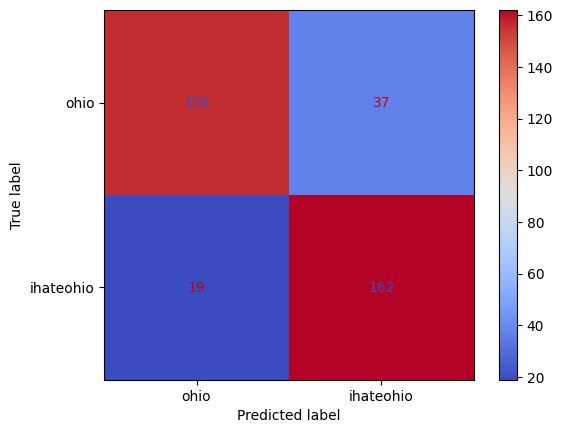

In [31]:
grid_search(tfvec_ada, tfvec_ada_params, 'TfVec AdaBoost')

In [32]:
tfvec_ada_2 = Pipeline([
        ('tfvec', TfidfVectorizer(stop_words=None)),
        ('ada', AdaBoostClassifier(random_state=42))
])

tfvec_ada_params_2 = {
    'ada__n_estimators': [400, 450, 500],
    'ada__learning_rate': [0.6, 0.7, 0.8],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'ada__learning_rate': 0.7, 'ada__n_estimators': 400}  

Best Estimator Cross Val Score: 0.83891
TfVec AdaBoost_v2 Training Score: 0.92848
TfVec AdaBoost_v2 Testing Score: 0.85027
Misclassification Rate: 0.14973 

Best estimator confusion matrix:


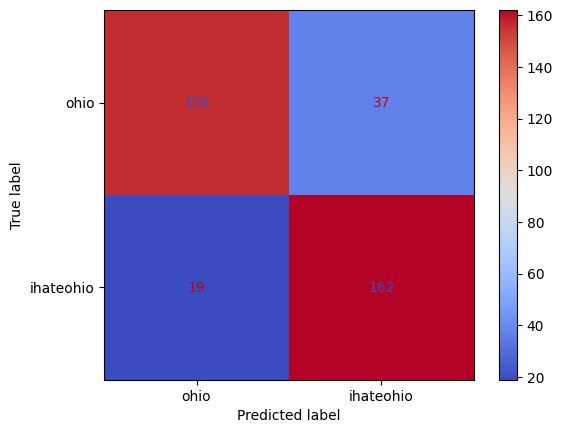

In [33]:
grid_search(tfvec_ada_2, tfvec_ada_params_2, 'TfVec AdaBoost_v2')

### Analysis

The CVec version 2 model above surpassed the prior AdaBoost high score of 0.85561 by a very slim margin. Because there is a trade-off between n_estimators and learning_rate, I inversely shifted the range of the two hyperparameters, and this specific model seemed to prefer the lower learning rate and higher amount of estimators (the TfVec model did not change when these were edited).

The three other models did not perform as well as the no-param CountVectorizer model, but the Tfidf models above both scored higher than the earlier Tfidf Ada scores.

Though slightly under the GradientBoost top score, AdaBoost is another great option to test on the final model.

---

## Decision Tree Classifier

In [34]:
cvec_dtree = Pipeline([
        ('cvec', CountVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

cvec_dtree_params = {
        'cvec__stop_words': [None, 'english'],
        'dt__max_depth': [2, 3, 4],
        'dt__max_features': [10, 20, 'sqrt'] 
}

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Params: {'cvec__stop_words': None, 'dt__max_depth': 4, 'dt__max_features': 'sqrt'}  

Best Estimator Cross Val Score: 0.71795
CVec Decision Tree Training Score: 0.68249
CVec Decision Tree Testing Score: 0.68984
Misclassification Rate: 0.31016 

Best estimator confusion matrix:


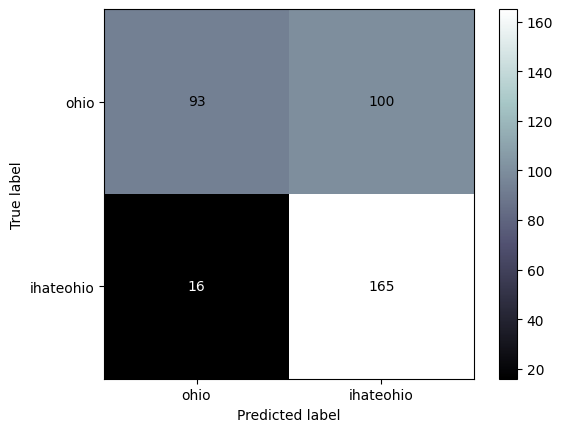

In [35]:
grid_search(cvec_dtree, cvec_dtree_params, 'CVec Decision Tree')

In [36]:
cvec_dtree_2 = Pipeline([
        ('cvec', CountVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

cvec_dtree_params_2 = {
        'dt__max_depth': [5, 6, 7],
        'dt__max_features': [1500, 2000, 3000, 3500, 'sqrt']
}

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'dt__max_depth': 6, 'dt__max_features': 3500}  

Best Estimator Cross Val Score: 0.81752
CVec Decision Tree_v2 Training Score: 0.8496
CVec Decision Tree_v2 Testing Score: 0.84492
Misclassification Rate: 0.15508 

Best estimator confusion matrix:


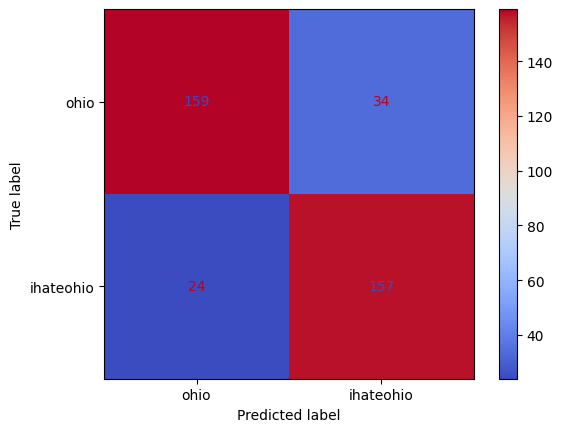

In [37]:
grid_search(cvec_dtree_2, cvec_dtree_params_2, 'CVec Decision Tree_v2')

In [38]:
tfvec_dtree = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
])

tfvec_dtree_params = {
        'dt__max_depth': [5, 6, 7],
        'dt__max_features': [1500, 2000, 3000, 3500, 'sqrt']
}

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best Params: {'dt__max_depth': 7, 'dt__max_features': 3500}  

Best Estimator Cross Val Score: 0.81952
TfVec Decision Tree Training Score: 0.875
TfVec Decision Tree Testing Score: 0.82888
Misclassification Rate: 0.17112 

Best estimator confusion matrix:


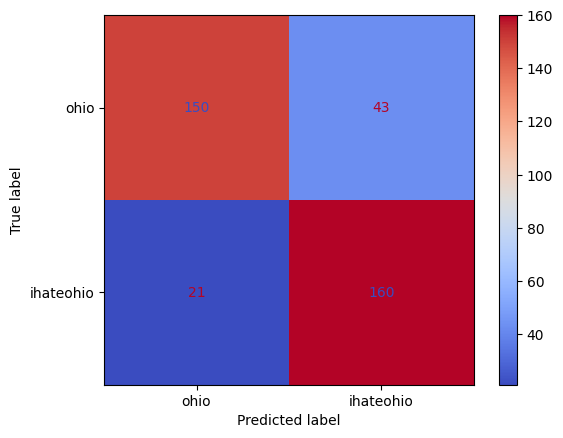

In [39]:
grid_search(tfvec_dtree, tfvec_dtree_params, 'TfVec Decision Tree')

### Analysis

My original strategy of being conservative with the amount of features allowed in the model did not seem to pay off. 

After increasing the depth and feature range, the CVec model performed a lot better, though not as well as the untuned model. The Tfidf did see a dip in train score, but also a slight improvement in the test score compared to the first model.

These scores aren't quite as high as the others, so I probably will not use Decision Tree Classification in my final model.

---

## Random Forest Classifier

In [40]:
cvec_rf = Pipeline([
        ('cvec', CountVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
])

cvec_rf_params = {
        'cvec__stop_words': [None, 'english'],
        'rf__max_depth': [5, 6, 7],
        'rf__n_estimators': [1000, 1500, 2000, 'sqrt'],
        'rf__max_samples': [500, 1000, None]
}

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'cvec__stop_words': None, 'rf__max_depth': 7, 'rf__max_samples': None, 'rf__n_estimators': 1000}  

Best Estimator Cross Val Score: 0.80615
CVec Random Forest Training Score: 0.81885
CVec Random Forest Testing Score: 0.8262
Misclassification Rate: 0.1738 

Best estimator confusion matrix:


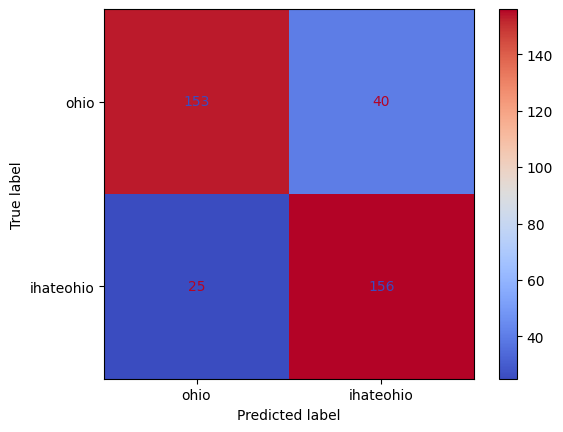

In [41]:
grid_search(cvec_rf, cvec_rf_params, 'CVec Random Forest')

In [42]:
cvec_rf_2 = Pipeline([
        ('cvec', CountVectorizer(stop_words=None)),
        ('rf', RandomForestClassifier(random_state=42))
])

cvec_rf_params_2 = {
        'rf__max_depth': [6, 7, 8],
        'rf__n_estimators': [800, 1000, 1500],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'rf__max_depth': 8, 'rf__n_estimators': 1000}  

Best Estimator Cross Val Score: 0.81016
CVec Random Forest_v2 Training Score: 0.82286
CVec Random Forest_v2 Testing Score: 0.8262
Misclassification Rate: 0.1738 

Best estimator confusion matrix:


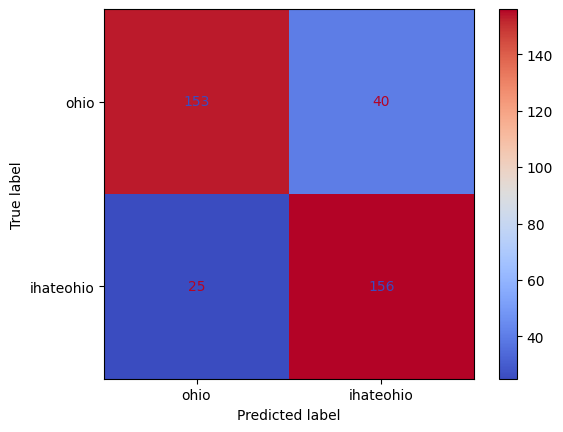

In [43]:
grid_search(cvec_rf_2, cvec_rf_params_2, 'CVec Random Forest_v2')

In [44]:
tfvec_rf = Pipeline([
        ('tfvec', TfidfVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
])

tfvec_rf_params = {
        'rf__max_depth': [6, 7, 8],
        'rf__n_estimators': [800, 1000, 1500],
}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'rf__max_depth': 8, 'rf__n_estimators': 800}  

Best Estimator Cross Val Score: 0.81083
TfVec Random Forest Training Score: 0.83021
TfVec Random Forest Testing Score: 0.8262
Misclassification Rate: 0.1738 

Best estimator confusion matrix:


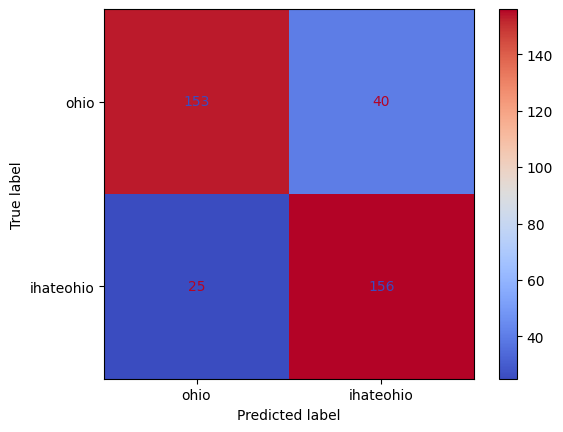

In [45]:
grid_search(tfvec_rf, tfvec_rf_params, 'TfVec Random Forest')

### Analysis

I was somewhat surprised here, because the Random Forest model made the same prediction three times, and scored the same in all three trials, even with varied 'best_params.' 

It underperformed compared to the Decision Tree models above, and also scored worse than the RF models without hyperparameters. 

Overall, none of these models meet the threshold of 0.85 so I will not be moving forward with RF trials.

---

## Model Evaluation

In [46]:
grid_search_df.to_csv('../datasets/model_tuning.csv')

grid_search_df

,model_used,cross_val_score,train_score,test_score,misclass_rate,best_param_1,best_param_2,best_param_3,best_param_4,best_param_5,best_param_6
0,CVec Logistic Regression,0.848920,0.901738,0.863636,0.136364,"(cvec__max_df, 0.7)","(cvec__max_features, 1500)","(cvec__min_df, 1)","(cvec__stop_words, None)","(lr__C, 10)","(lr__penalty, l1)"
1,CVec Logistic Regression_v2,0.848920,0.901738,0.863636,0.136364,"(cvec__max_df, 0.6)","(cvec__max_features, 1500)","(lr__C, 10)",-,-,-
2,TfVec Logistic Regression,0.836231,0.921123,0.855615,0.144385,"(lr__C, 10)","(tfvec__max_df, 0.6)","(tfvec__max_features, 1000)","(tfvec__min_df, 1)",-,-
3,TfVec GBoost,0.841579,0.928476,0.858289,0.141711,"(gb__learning_rate, 0.8)","(gb__max_depth, 8)","(gb__n_estimators, 150)","(tfvec__stop_words, None)",-,-
4,TfVec GBoost_v2,0.836903,0.921123,0.858289,0.141711,"(gb__learning_rate, 0.8)","(gb__max_depth, 5)","(gb__n_iter_no_change, 20)","(gb__tol, 0.03)","(gb__validation_fraction, 0.05)",-
5,CVec GBoost,0.839573,0.928476,0.871658,0.128342,"(gb__learning_rate, 0.7)","(gb__max_depth, 7)","(gb__n_estimators, 100)",-,-,-
6,CVec Bagging,0.806824,0.885695,0.826203,0.173797,"(bag__max_features, 400)","(bag__n_estimators, 600)","(cvec__stop_words, None)",-,-,-
7,CVec Bagging_v2,0.819516,0.849599,0.855615,0.144385,"(bag__max_samples, 400)","(bag__n_estimators, 200)","(cvec__stop_words, None)",-,-,-
8,TfVec Bagging,0.820855,0.852941,0.842246,0.157754,"(bag__max_samples, 400)","(bag__n_estimators, 200)",-,-,-,-
9,Cvec AdaBoost,0.833561,0.928476,0.850267,0.149733,"(ada__learning_rate, 0.8)","(ada__n_estimators, 300)","(cvec__stop_words, None)",-,-,-


In [47]:
grid_search_df.describe()

,cross_val_score,train_score,test_score,misclass_rate
count,19.000000,19.000000,19.000000,19.000000
mean,0.822477,0.878096,0.839572,0.160428
std,0.028890,0.062134,0.039165,0.039165
min,0.717950,0.682487,0.689840,0.128342
25%,0.814174,0.849599,0.827540,0.141711
50%,0.833561,0.901738,0.850267,0.149733
75%,0.838915,0.928476,0.858289,0.172460
max,0.848920,0.928476,0.871658,0.310160


The average accuracy among these test scores was 0.839, a big increase from the untuned models' average, and would likely be even greater without the one very low score from the first CVec Decision Tree model.

I do think that a few of these models are slightly overfit, but the mean standard deviation for test and train scores are notable improvements in performance from the previous models. In theory, this means that these models are more predictable and, I'd guess, would score over 0.85 on the test set at least half of the time (given the median test score).

I'm going to combine a few of the top-scoring models into a stacked final model to hopefully further increase the scores.

In [48]:
grid_search_df[['model_used', 'test_score']].sort_values(by=['test_score'], ascending=False).head(10)

,model_used,test_score
5,CVec GBoost,0.871658
0,CVec Logistic Regression,0.863636
10,CVec AdaBoost_v2,0.863636
1,CVec Logistic Regression_v2,0.863636
3,TfVec GBoost,0.858289
4,TfVec GBoost_v2,0.858289
2,TfVec Logistic Regression,0.855615
7,CVec Bagging_v2,0.855615
12,TfVec AdaBoost_v2,0.850267
11,TfVec AdaBoost,0.850267


---

## Stacking Best Models

In [49]:
X = reddit['selftext']
y = reddit['subreddit_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [50]:
level1_est = [
    ('gboost_pipe', Pipeline([
        ('cvec', CountVectorizer()),
        ('gb', GradientBoostingClassifier(learning_rate=0.7, max_depth=7, n_estimators=100))
    ])),
    ('bag_pipe', Pipeline([
        ('cvec', CountVectorizer()),
        ('bag', BaggingClassifier(max_samples=400, n_estimators=200))
    ]))
]

stacked_model = StackingClassifier(estimators=level1_est, final_estimator=LogisticRegression(solver='saga', C=10, penalty='l1'))

In [51]:
print(cross_val_score(stacked_model, X_train, y_train).mean())
stacked_model.fit(X_train, y_train)

0.8322296544035674


StackingClassifier(estimators=[('gboost_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('gb',
                                                 GradientBoostingClassifier(learning_rate=0.7,
                                                                            max_depth=7))])),
                               ('bag_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('bag',
                                                 BaggingClassifier(max_samples=400,
                                                                   n_estimators=200))]))],
                   final_estimator=LogisticRegression(C=10, penalty='l1',
                                                      solver='saga'))

In [52]:
print(f'Training score: {stacked_model.score(X_train, y_train)}')
print(f'Testing score: {stacked_model.score(X_test, y_test)}')

Training score: 0.928475935828877
Testing score: 0.8636363636363636


In [53]:
X = reddit['selftext']
y = reddit['subreddit_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [54]:
level1_est2 = [
    ('ada_pipe', Pipeline([
        ('cvec', CountVectorizer()),
        ('ada', AdaBoostClassifier(learning_rate=0.65, n_estimators=400, random_state=42))
    ])),
    ('bag_pipe', Pipeline([
        ('cvec', CountVectorizer()),
        ('bag', BaggingClassifier(max_samples=400, n_estimators=200, random_state=42))
    ]))
]

stacked_model_2 = StackingClassifier(estimators=level1_est2, final_estimator=LogisticRegression(solver='saga', C=10, penalty='l1', random_state=42))

In [55]:
print(cross_val_score(stacked_model_2, X_train, y_train).mean())
stacked_model_2.fit(X_train, y_train)

0.8262073578595318


StackingClassifier(estimators=[('ada_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('ada',
                                                 AdaBoostClassifier(learning_rate=0.65,
                                                                    n_estimators=400,
                                                                    random_state=42))])),
                               ('bag_pipe',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('bag',
                                                 BaggingClassifier(max_samples=400,
                                                                   n_estimators=200,
                                                                   random_state=42))]))],
                   final_estimator=LogisticRegression(C=10, penalty='l1',
                                                      random_state=42,
                                                      solver='saga'))

In [56]:
print(f'Training score: {stacked_model_2.score(X_train, y_train)}')
print(f'Testing score: {stacked_model_2.score(X_test, y_test)}')

Training score: 0.9030748663101604
Testing score: 0.8556149732620321


---

## Conclusion

The stacked models performed well, but did not beat the first tuned CountVectorizer GBoost model above. This means that the final overall model to move forward with in my classification tasks for the state of Ohio is the Gradient Boost Classifier, using CountVectorizer, a learning rate of 0.7, a max depth of 7, and n estimators set to 100.

Overall, I'm happy with the scores of the tuned models, and I have at least a few that could reliably be used to classify posts correctly 85% of the time.